# Binary Classification Model for [PROJECT NAME] Using Python and AutoKeras version 1
### David Lowe
### September 23, 2020

Template Credit: Adapted from a template made available by Dr. Jason Brownlee of Machine Learning Mastery. [https://machinelearningmastery.com/]

SUMMARY: The purpose of this project is to construct a predictive model using various machine learning algorithms and to document the end-to-end steps using a template. The [PROJECT NAME] dataset is a binary classification situation where we are trying to predict one of the two possible outcomes.

INTRODUCTION: [Sample Paragraph - The data file patterns obtained by bouncing sonar signals off a metal cylinder or a rock at various angles and under various conditions. The transmitted sonar signal is a frequency-modulated chirp, rising in frequency. The data set contains signals obtained from a variety of different aspect angles, spanning 90 degrees for the cylinder and 180 degrees for the rock. Each pattern is a set of 60 numbers in the range 0.0 to 1.0. Each number represents the energy within a particular frequency band, integrated over a certain period of time.]

ANALYSIS: [Sample Paragraph - After a series of modeling trials, the AutoKeras system processed the validation dataset with a maximum accuracy score of 100.00%. When we applied the best AutoKeras model to the previously unseen test dataset, we obtained an accuracy score of 73.81%.]

CONCLUSION: [Sample Paragraph - In this iteration, the best TensorFlow model generated by AutoKeras appeared to be suitable for modeling this dataset. We should consider expermenting with AutoKeras for further modeling.]

Dataset Used: [PROJECT NAME] Data Set

Dataset ML Model: Binary classification with [numerical | categorical] attributes

Dataset Reference: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

One potential source of performance benchmark: [https://archive.ics.uci.edu/ml/datasets/Connectionist+Bench+%28Sonar%2C+Mines+vs.+Rocks%29]

Any predictive modeling machine learning project generally can be broken down into about six major tasks:

1. Prepare Environment
2. Summarize and Visualize Data
3. Pre-process Data
4. Train and Evaluate Models
5. Finalize Model and Present Analysis

## Task 1 - Prepare Environment

In [1]:
# Install the necessary packages for Colab
# !pip install python-dotenv PyMySQL

In [2]:
# Retrieve the GPU information from Colab
# gpu_info = !nvidia-smi
# gpu_info = '\n'.join(gpu_info)
# if gpu_info.find('failed') >= 0:
#     print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
#     print('and then re-execute this cell.')
# else:
#     print(gpu_info)

In [3]:
# Retrieve the memory configuration from Colab
# from psutil import virtual_memory
# ram_gb = virtual_memory().total / 1e9
# print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

# if ram_gb < 20:
#     print('To enable a high-RAM runtime, select the Runtime → "Change runtime type"')
#     print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
#     print('re-execute this cell.')
# else:
#     print('You are using a high-RAM runtime!')

In [4]:
# Retrieve the CPU information
ncpu = !nproc
print("The number of available CPUs is:", ncpu[0])

The number of available CPUs is: 4


### 1.a) Load libraries and modules

In [5]:
# Set the random seed number for reproducible results
seedNum = 888

In [6]:
import random
random.seed(seedNum)
import numpy as np
np.random.seed(seedNum)
import pandas as pd
import matplotlib.pyplot as plt
import math
import boto3
from datetime import datetime
from dotenv import load_dotenv
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
tf.random.set_seed(seedNum)
from tensorflow import keras
from autokeras import StructuredDataClassifier

### 1.b) Set up the controlling parameters and functions

In [7]:
# Begin the timer for the script processing
startTimeScript = datetime.now()

# Set up the number of CPU cores available for multi-thread processing
n_jobs = 1

# Set up the flag to stop sending progress emails (setting to True will send status emails!)
notifyStatus = False

# Set up the parent directory location for loading the dotenv files
useColab = False
if useColab:
    # Mount Google Drive locally for storing files
    from google.colab import drive
    drive.mount('/content/gdrive')
    gdrivePrefix = '/content/gdrive/My Drive/Colab_Downloads/'
    env_path = '/content/gdrive/My Drive/Colab Notebooks/'
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Set up the dotenv file for retrieving environment variables
useLocalPC = False
if useLocalPC:
    env_path = "/Users/david/PycharmProjects/"
    dotenv_path = env_path + "python_script.env"
    load_dotenv(dotenv_path=dotenv_path)

# Configure the plotting style
plt.style.use('seaborn')

# Set Pandas options
pd.set_option("display.max_rows", 500)
pd.set_option("display.width", 140)

# Set the percentage sizes for splitting the dataset
test_set_size = 0.2
val_set_size = 0.25

# Set the number of folds and iterations for cross validation
n_folds = 5
n_iterations = 2

# Set various default modeling parameters
# Set various default Keras modeling parameters
default_loss = keras.losses.BinaryCrossentropy()
default_metrics = [keras.metrics.BinaryAccuracy(name='accuracy')]
default_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
default_kernel_init = tf.keras.initializers.GlorotUniform(seed=seedNum)
default_epoch = 100
default_batch = 32
default_trial = 100

In [8]:
# Set up the email notification function
def status_notify(msg_text):
    access_key = os.environ.get('SNS_ACCESS_KEY')
    secret_key = os.environ.get('SNS_SECRET_KEY')
    aws_region = os.environ.get('SNS_AWS_REGION')
    topic_arn = os.environ.get('SNS_TOPIC_ARN')
    if (access_key is None) or (secret_key is None) or (aws_region is None):
        sys.exit("Incomplete notification setup info. Script Processing Aborted!!!")
    sns = boto3.client('sns', aws_access_key_id=access_key, aws_secret_access_key=secret_key, region_name=aws_region)
    response = sns.publish(TopicArn=topic_arn, Message=msg_text)
    if response['ResponseMetadata']['HTTPStatusCode'] != 200 :
        print('Status notification not OK with HTTP status code:', response['ResponseMetadata']['HTTPStatusCode'])

In [9]:
# Reset the random number generators
def reset_random(x):
    random.seed(x)
    np.random.seed(x)
    tf.random.set_seed(x)

In [10]:
# Clean up outstanding AutoKeras working folder and files
!rm -rf structured_data_classifier/

In [11]:
if notifyStatus: status_notify("Task 1 - Prepare Environment has begun! " + datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 1.c) Load dataset

In [12]:
dataset_path = 'https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'
attrNames = ['attr' + str(i).zfill(2) for i in range(1,61)]
colNames = attrNames + ['target']
Xy_original = pd.read_csv(dataset_path, names=colNames, sep=',', header=None, index_col=False)

# Take a peek at the dataframe after import
Xy_original.head(10)

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,target
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R
5,0.0286,0.0453,0.0277,0.0174,0.0384,0.0990,0.1201,0.1833,0.2105,0.3039,...,0.0045,0.0014,0.0038,0.0013,0.0089,0.0057,0.0027,0.0051,0.0062,R
6,0.0317,0.0956,0.1321,0.1408,0.1674,0.1710,0.0731,0.1401,0.2083,0.3513,...,0.0201,0.0248,0.0131,0.0070,0.0138,0.0092,0.0143,0.0036,0.0103,R
7,0.0519,0.0548,0.0842,0.0319,0.1158,0.0922,0.1027,0.0613,0.1465,0.2838,...,0.0081,0.0120,0.0045,0.0121,0.0097,0.0085,0.0047,0.0048,0.0053,R
8,0.0223,0.0375,0.0484,0.0475,0.0647,0.0591,0.0753,0.0098,0.0684,0.1487,...,0.0145,0.0128,0.0145,0.0058,0.0049,0.0065,0.0093,0.0059,0.0022,R
9,0.0164,0.0173,0.0347,0.0070,0.0187,0.0671,0.1056,0.0697,0.0962,0.0251,...,0.0090,0.0223,0.0179,0.0084,0.0068,0.0032,0.0035,0.0056,0.0040,R


In [13]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   attr01  208 non-null    float64
 1   attr02  208 non-null    float64
 2   attr03  208 non-null    float64
 3   attr04  208 non-null    float64
 4   attr05  208 non-null    float64
 5   attr06  208 non-null    float64
 6   attr07  208 non-null    float64
 7   attr08  208 non-null    float64
 8   attr09  208 non-null    float64
 9   attr10  208 non-null    float64
 10  attr11  208 non-null    float64
 11  attr12  208 non-null    float64
 12  attr13  208 non-null    float64
 13  attr14  208 non-null    float64
 14  attr15  208 non-null    float64
 15  attr16  208 non-null    float64
 16  attr17  208 non-null    float64
 17  attr18  208 non-null    float64
 18  attr19  208 non-null    float64
 19  attr20  208 non-null    float64
 20  attr21  208 non-null    float64
 21  attr22  208 non-null    float64
 22  at

In [14]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


In [15]:
Xy_original.isnull().sum()

attr01    0
attr02    0
attr03    0
attr04    0
attr05    0
attr06    0
attr07    0
attr08    0
attr09    0
attr10    0
attr11    0
attr12    0
attr13    0
attr14    0
attr15    0
attr16    0
attr17    0
attr18    0
attr19    0
attr20    0
attr21    0
attr22    0
attr23    0
attr24    0
attr25    0
attr26    0
attr27    0
attr28    0
attr29    0
attr30    0
attr31    0
attr32    0
attr33    0
attr34    0
attr35    0
attr36    0
attr37    0
attr38    0
attr39    0
attr40    0
attr41    0
attr42    0
attr43    0
attr44    0
attr45    0
attr46    0
attr47    0
attr48    0
attr49    0
attr50    0
attr51    0
attr52    0
attr53    0
attr54    0
attr55    0
attr56    0
attr57    0
attr58    0
attr59    0
attr60    0
target    0
dtype: int64

In [16]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.d) Data Cleaning

In [17]:
# Standardize the class column to the name of targetVar if required
Xy_original = Xy_original.rename(columns={'target': 'targetVar'})

# Dropping features
# Xy_original.drop(columns=['column1','column2','column3'], inplace=True)

# Impute missing values
# Xy_original['col_name'].fillna('someValue', inplace=True)
# Xy_original['col_name'].fillna(value=Xy_original['col_name'].median(), inplace=True)

# Convert columns from one data type to another
# Xy_original.column_name = Xy_original.column_name.astype('int')
# Xy_original.column_name = Xy_original.column_name.astype('category')

# Take a peek at the dataframe after cleaning
Xy_original.head()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60,targetVar
0,0.0200,0.0371,0.0428,0.0207,0.0954,0.0986,0.1539,0.1601,0.3109,0.2111,...,0.0027,0.0065,0.0159,0.0072,0.0167,0.0180,0.0084,0.0090,0.0032,R
1,0.0453,0.0523,0.0843,0.0689,0.1183,0.2583,0.2156,0.3481,0.3337,0.2872,...,0.0084,0.0089,0.0048,0.0094,0.0191,0.0140,0.0049,0.0052,0.0044,R
2,0.0262,0.0582,0.1099,0.1083,0.0974,0.2280,0.2431,0.3771,0.5598,0.6194,...,0.0232,0.0166,0.0095,0.0180,0.0244,0.0316,0.0164,0.0095,0.0078,R
3,0.0100,0.0171,0.0623,0.0205,0.0205,0.0368,0.1098,0.1276,0.0598,0.1264,...,0.0121,0.0036,0.0150,0.0085,0.0073,0.0050,0.0044,0.0040,0.0117,R
4,0.0762,0.0666,0.0481,0.0394,0.0590,0.0649,0.1209,0.2467,0.3564,0.4459,...,0.0031,0.0054,0.0105,0.0110,0.0015,0.0072,0.0048,0.0107,0.0094,R


In [18]:
Xy_original.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 208 entries, 0 to 207
Data columns (total 61 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   attr01     208 non-null    float64
 1   attr02     208 non-null    float64
 2   attr03     208 non-null    float64
 3   attr04     208 non-null    float64
 4   attr05     208 non-null    float64
 5   attr06     208 non-null    float64
 6   attr07     208 non-null    float64
 7   attr08     208 non-null    float64
 8   attr09     208 non-null    float64
 9   attr10     208 non-null    float64
 10  attr11     208 non-null    float64
 11  attr12     208 non-null    float64
 12  attr13     208 non-null    float64
 13  attr14     208 non-null    float64
 14  attr15     208 non-null    float64
 15  attr16     208 non-null    float64
 16  attr17     208 non-null    float64
 17  attr18     208 non-null    float64
 18  attr19     208 non-null    float64
 19  attr20     208 non-null    float64
 20  attr21    

In [19]:
Xy_original.describe()

,attr01,attr02,attr03,attr04,attr05,attr06,attr07,attr08,attr09,attr10,...,attr51,attr52,attr53,attr54,attr55,attr56,attr57,attr58,attr59,attr60
count,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,...,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000,208.000000
mean,0.029164,0.038437,0.043832,0.053892,0.075202,0.104570,0.121747,0.134799,0.178003,0.208259,...,0.016069,0.013420,0.010709,0.010941,0.009290,0.008222,0.007820,0.007949,0.007941,0.006507
std,0.022991,0.032960,0.038428,0.046528,0.055552,0.059105,0.061788,0.085152,0.118387,0.134416,...,0.012008,0.009634,0.007060,0.007301,0.007088,0.005736,0.005785,0.006470,0.006181,0.005031
min,0.001500,0.000600,0.001500,0.005800,0.006700,0.010200,0.003300,0.005500,0.007500,0.011300,...,0.000000,0.000800,0.000500,0.001000,0.000600,0.000400,0.000300,0.000300,0.000100,0.000600
25%,0.013350,0.016450,0.018950,0.024375,0.038050,0.067025,0.080900,0.080425,0.097025,0.111275,...,0.008425,0.007275,0.005075,0.005375,0.004150,0.004400,0.003700,0.003600,0.003675,0.003100
50%,0.022800,0.030800,0.034300,0.044050,0.062500,0.092150,0.106950,0.112100,0.152250,0.182400,...,0.013900,0.011400,0.009550,0.009300,0.007500,0.006850,0.005950,0.005800,0.006400,0.005300
75%,0.035550,0.047950,0.057950,0.064500,0.100275,0.134125,0.154000,0.169600,0.233425,0.268700,...,0.020825,0.016725,0.014900,0.014500,0.012100,0.010575,0.010425,0.010350,0.010325,0.008525
max,0.137100,0.233900,0.305900,0.426400,0.401000,0.382300,0.372900,0.459000,0.682800,0.710600,...,0.100400,0.070900,0.039000,0.035200,0.044700,0.039400,0.035500,0.044000,0.036400,0.043900


In [20]:
Xy_original.isnull().sum()

attr01       0
attr02       0
attr03       0
attr04       0
attr05       0
attr06       0
attr07       0
attr08       0
attr09       0
attr10       0
attr11       0
attr12       0
attr13       0
attr14       0
attr15       0
attr16       0
attr17       0
attr18       0
attr19       0
attr20       0
attr21       0
attr22       0
attr23       0
attr24       0
attr25       0
attr26       0
attr27       0
attr28       0
attr29       0
attr30       0
attr31       0
attr32       0
attr33       0
attr34       0
attr35       0
attr36       0
attr37       0
attr38       0
attr39       0
attr40       0
attr41       0
attr42       0
attr43       0
attr44       0
attr45       0
attr46       0
attr47       0
attr48       0
attr49       0
attr50       0
attr51       0
attr52       0
attr53       0
attr54       0
attr55       0
attr56       0
attr57       0
attr58       0
attr59       0
attr60       0
targetVar    0
dtype: int64

In [21]:
print('Total number of NaN in the dataframe: ', Xy_original.isnull().sum().sum())

Total number of NaN in the dataframe:  0


### 1.e) Splitting Data into Sets

In [22]:
# Use variable totCol to hold the number of columns in the dataframe
totCol = len(Xy_original.columns)

# Set up variable totAttr for the total number of attribute columns
totAttr = totCol-1

# targetCol variable indicates the column location of the target/class variable
# If the first column, set targetCol to 1. If the last column, set targetCol to totCol
# If (targetCol <> 1) and (targetCol <> totCol), be aware when slicing up the dataframes for visualization
targetCol = totCol

In [23]:
# We create attribute-only and target-only datasets (X_original and y_original)
# for various visualization and cleaning/transformation operations

if targetCol == totCol:
    X_original = Xy_original.iloc[:,0:totAttr]
    y_original = Xy_original.iloc[:,totAttr]
else:
    X_original = Xy_original.iloc[:,1:totCol]
    y_original = Xy_original.iloc[:,0]

print("Xy_original.shape: {} X_original.shape: {} y_original.shape: {}".format(Xy_original.shape, X_original.shape, y_original.shape))

Xy_original.shape: (208, 61) X_original.shape: (208, 60) y_original.shape: (208,)


In [24]:
# Split the data further into training, validation, and test datasets
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X_original, y_original, test_size=test_set_size, stratify=y_original, random_state=seedNum)
print("X_train_df.shape: {} y_train_df.shape: {}".format(X_train_df.shape, y_train_df.shape))
print("X_test_df.shape: {} y_test_df.shape: {}".format(X_test_df.shape, y_test_df.shape))

X_train_df.shape: (166, 60) y_train_df.shape: (166,)
X_test_df.shape: (42, 60) y_test_df.shape: (42,)


In [25]:
if notifyStatus: status_notify("Task 1 - Prepare Environment completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 2 - Summarize and Visualize Data

In [26]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [27]:
# Set up the number of row and columns for visualization display. dispRow * dispCol should be >= totAttr
dispCol = 4
if totAttr % dispCol == 0 :
    dispRow = totAttr // dispCol
else :
    dispRow = (totAttr // dispCol) + 1
    
# Set figure width to display the data visualization plots
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = dispCol*4
fig_size[1] = dispRow*4
plt.rcParams["figure.figsize"] = fig_size

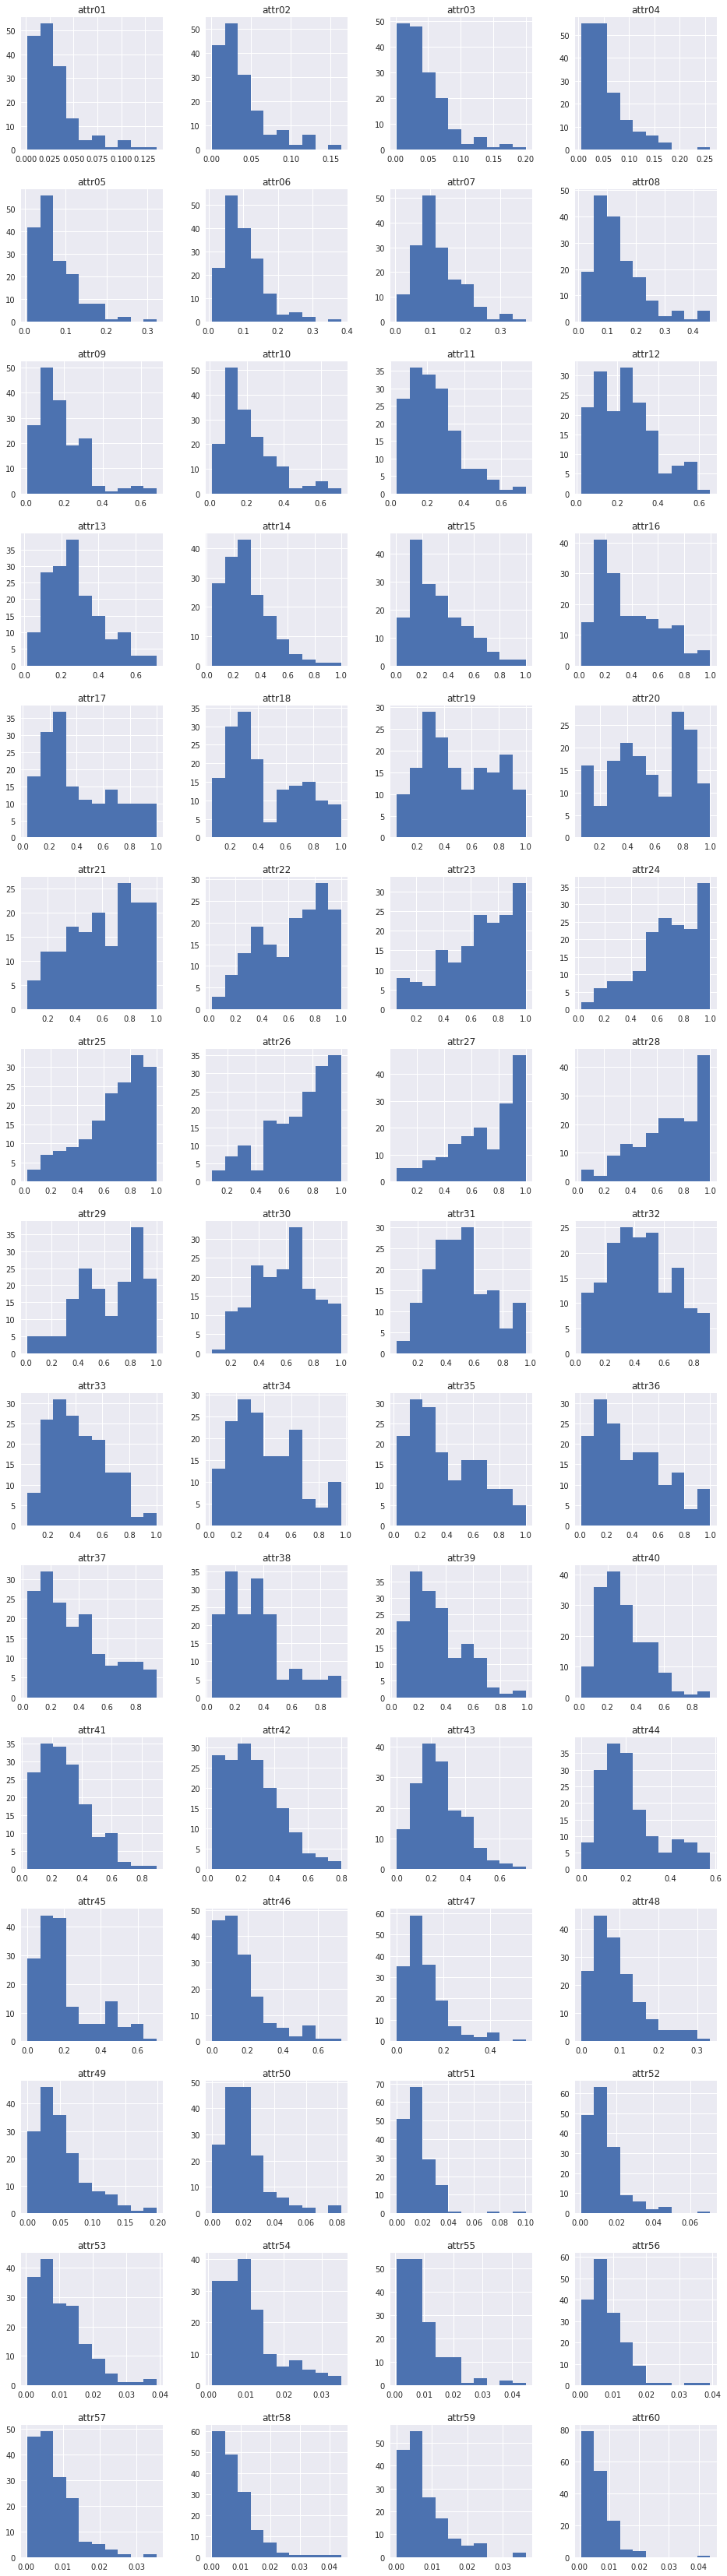

In [28]:
# Histograms for each attribute
X_train_df.hist(layout=(dispRow,dispCol))
plt.show()

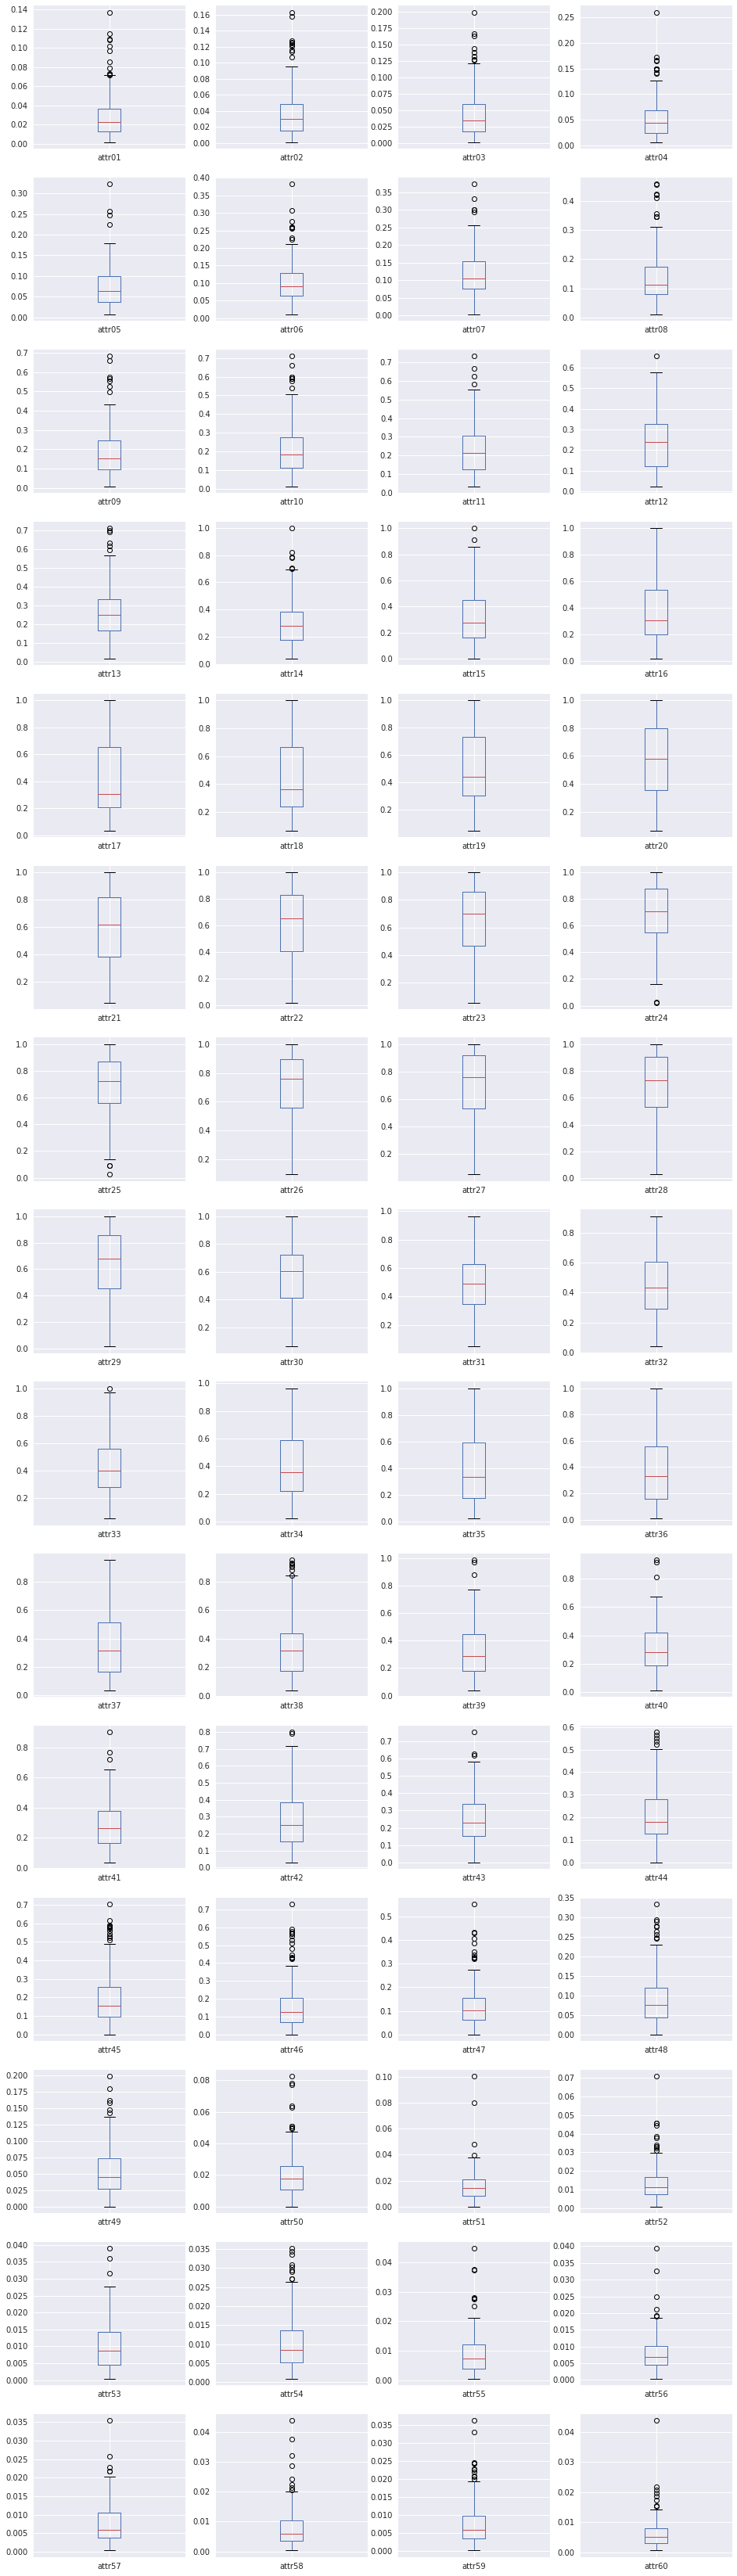

In [29]:
# Box and Whisker plot for each attribute
X_train_df.plot(kind='box', subplots=True, layout=(dispRow,dispCol))
plt.show()

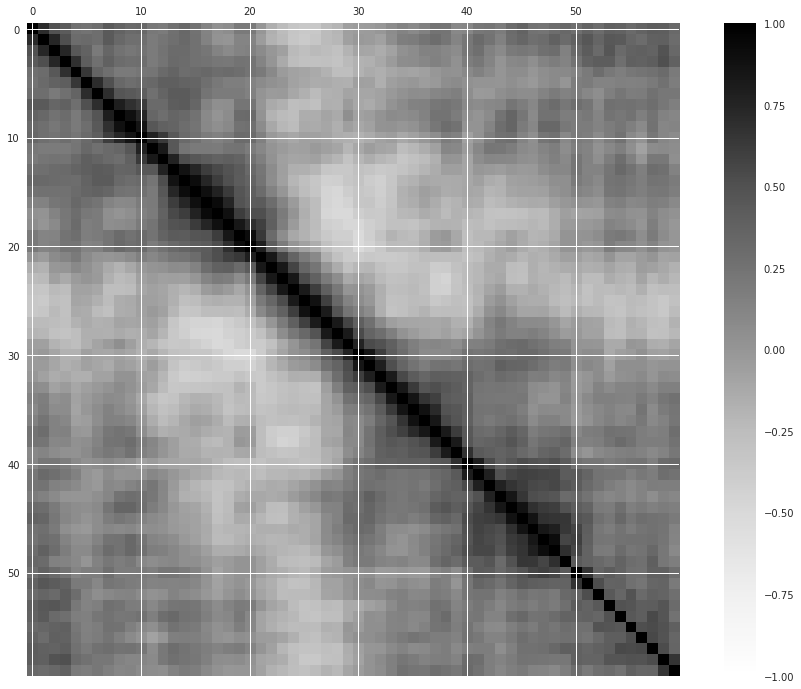

In [30]:
# Correlation matrix
fig = plt.figure(figsize=(16,12))
ax = fig.add_subplot(111)
correlations = X_train_df.corr(method='pearson')
cax = ax.matshow(correlations, vmin=-1, vmax=1)
fig.colorbar(cax)
plt.show()

In [31]:
if notifyStatus: status_notify("Task 2 - Summarize and Visualize Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 3 - Pre-process Data

In [32]:
if notifyStatus: status_notify("Task 3 - Pre-process Data has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

### 3.a) Feature Scaling

In [33]:
# Apply feature scaling and transformation
columns_to_scale = X_train_df.columns[X_train_df.dtypes == 'float'].tolist()
print('Columns to scale are:', columns_to_scale)
scaler = preprocessing.StandardScaler()
X_train_df[columns_to_scale] = scaler.fit_transform(X_train_df[columns_to_scale])
print(X_train_df.head())

Columns to scale are: ['attr01', 'attr02', 'attr03', 'attr04', 'attr05', 'attr06', 'attr07', 'attr08', 'attr09', 'attr10', 'attr11', 'attr12', 'attr13', 'attr14', 'attr15', 'attr16', 'attr17', 'attr18', 'attr19', 'attr20', 'attr21', 'attr22', 'attr23', 'attr24', 'attr25', 'attr26', 'attr27', 'attr28', 'attr29', 'attr30', 'attr31', 'attr32', 'attr33', 'attr34', 'attr35', 'attr36', 'attr37', 'attr38', 'attr39', 'attr40', 'attr41', 'attr42', 'attr43', 'attr44', 'attr45', 'attr46', 'attr47', 'attr48', 'attr49', 'attr50', 'attr51', 'attr52', 'attr53', 'attr54', 'attr55', 'attr56', 'attr57', 'attr58', 'attr59', 'attr60']
       attr01    attr02    attr03    attr04    attr05    attr06    attr07    attr08    attr09    attr10  ...    attr51    attr52  \
42  -0.348994 -0.202248 -0.056024 -0.628874 -1.186222 -0.982330  0.133452  0.027249 -0.918000 -1.118470  ... -0.886221 -0.452720   
199 -0.760019  1.144736 -0.193758 -0.779745 -1.272161 -0.804662 -0.158686 -0.334937 -0.092029  0.111565  ...  0.3

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3072: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.iloc._setitem_with_indexer((slice(None), indexer), value)
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:3037: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vi

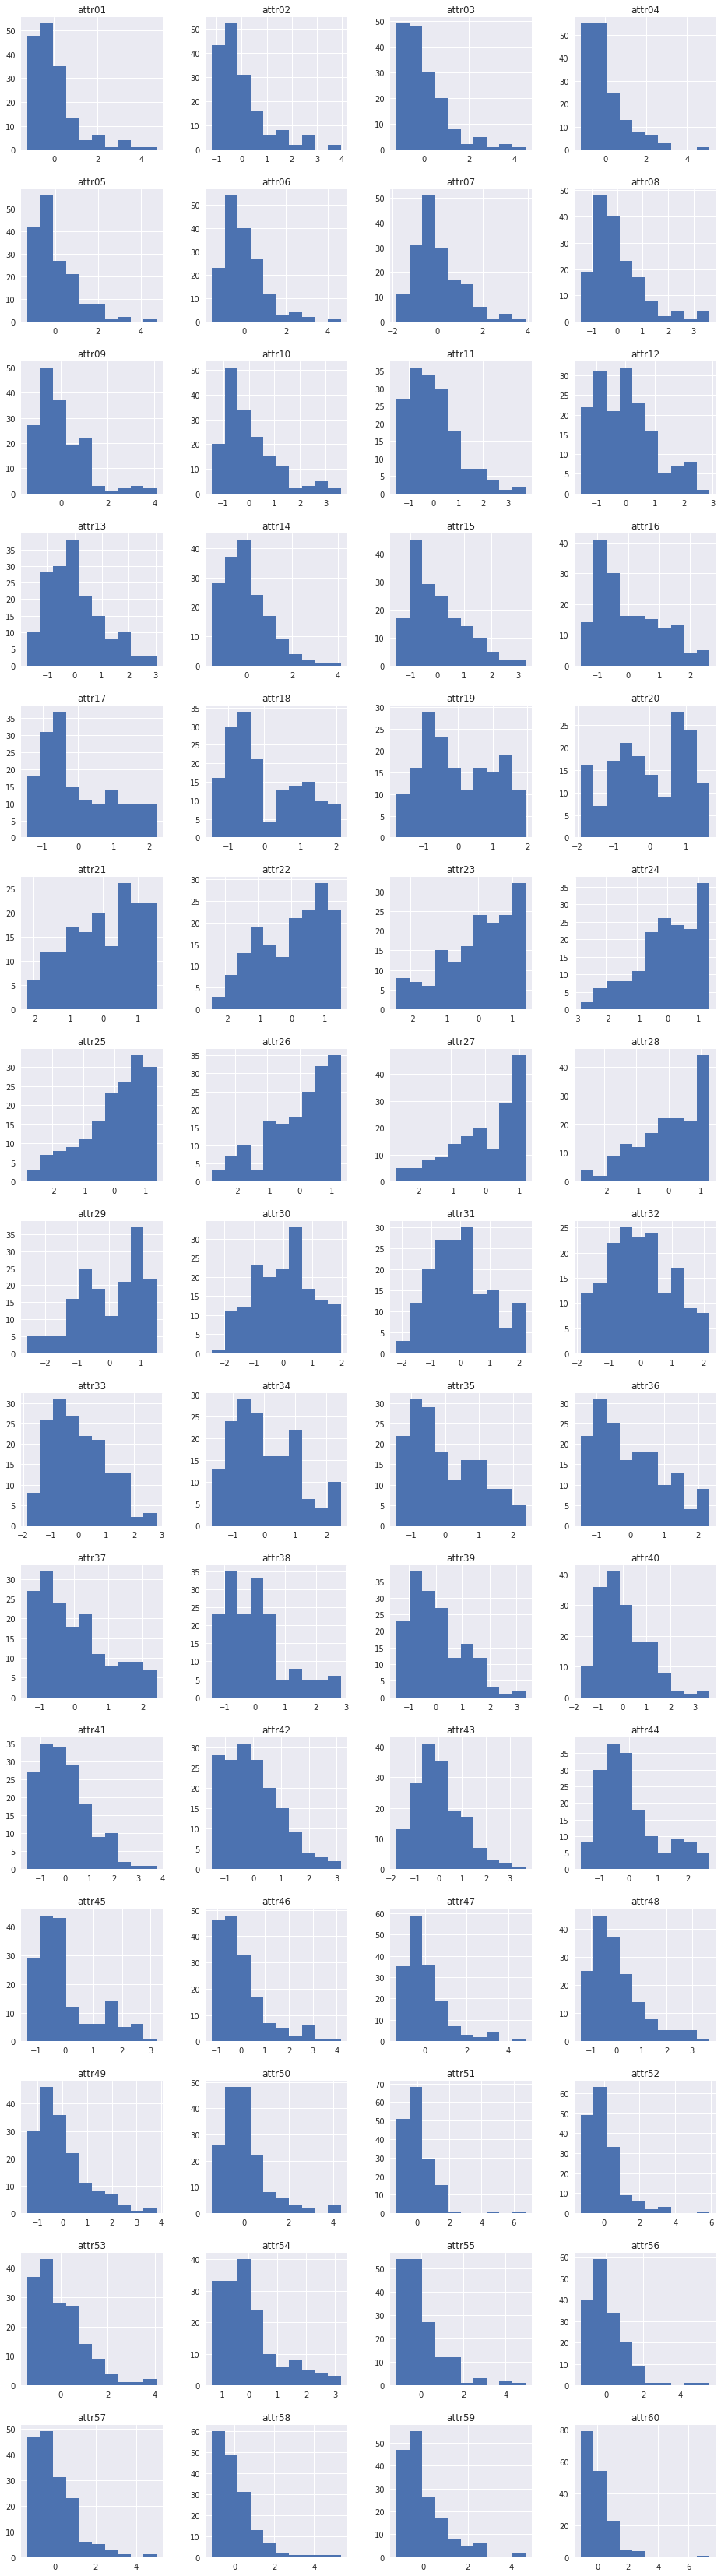

In [34]:
# Histograms for each attribute after pre-processing
X_train_df[columns_to_scale].hist(layout=(dispRow,dispCol))
plt.show()

In [35]:
# # Compose pipeline for the numerical and categorical features (Block #1 of 2)
# numeric_columns = X_train_df.select_dtypes(include=['int64','float64']).columns
# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
#     ('scaler', StandardScaler())
# ])
# categorical_columns = X_train_df.select_dtypes(include=['object','bool']).columns
# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='NA')),
#     ('onehot', OneHotEncoder(sparse=False, handle_unknown='ignore'))
# ])

# print("Number of numerical columns:", len(numeric_columns))
# print("Number of categorical columns:", len(categorical_columns))
# print("Total number of columns in the dataframe:", X_train_df.shape[1])

In [36]:
# # Compose pipeline for the numerical and categorical features (Block #2 of 2)
# preprocessor = ColumnTransformer(transformers=[
#     ('num', numeric_transformer, numeric_columns),
#     ('cat', categorical_transformer, categorical_columns)
# ])

# # Display the shapes of the training datasets for final inspection
# X_train = preprocessor.fit_transform(X_train_df)
# y_train = y_train_df.ravel()
# print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

In [37]:
# # Apply binning techniques with continuous data (Block #1 of 1)
# discrete_feature = preprocessing.Binarizer(threshold=0.0)
# discrete_feature = preprocessing.KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='kmeans')
# feature_binned = discrete_feature.fit_transform(X_original[['old_feature1']])
# X_train_df['new_feature1'] = feature_binned
# X_train_df['new_feature1'] = X_train_df['new_feature1'].astype('category')
# X_train_df.drop(columns=['old_feature1', 'old_feature2'], inplace=True)
# X_train_df.head()

### 3.c) Training Data Balancing

In [38]:
# Not applicable for this iteration of the project

In [39]:
# # Perform SMOTE transformation on the training data (Block #1 of 2)
# X_train_imbal = X_train_df.values
# y_train_imbal = y_train_df.values.ravel()
# print("X_train_imbal.shape: {} y_train_imbal.shape: {}".format(X_train_imbal.shape, y_train_imbal.shape))

In [40]:
# # Perform SMOTE transformation on the training data (Block #2 of 2)
# print ('Original class distribution - 1: {} | 0: {}'.format((y_train_imbal==1).sum(), (y_train_imbal==0).sum()))
# over_sample = SMOTE(sampling_strategy=0.05, random_state=seedNum)
# under_sample = RandomUnderSampler(sampling_strategy=1.0, random_state=seedNum)
# steps = [('o', over_sample), ('u', under_sample)]
# sample_pipeline = Pipeline(steps=steps)
# X_train, y_train = sample_pipeline.fit_resample(X_train_imbal, y_train_imbal)
# print ('Resampled class distribution - 1: {} | 0: {}'.format((y_train==1).sum(), (y_train==0).sum()))

### 3.d) Feature Selection

In [41]:
# Not applicable for this iteration of the project

In [42]:
# Find collinear features (Block #1 of 3)

# def findCorrelated(corrmat, cutoff = 0.75):    

# ### search correlation matrix and identify pairs that if removed would reduce pair-wise correlations
# # args:
#     # corrmat: a correlation matrix
#     # cutoff: pairwise absolute correlation cutoff
# # returns:
#     # variables to removed

#     if(len(corrmat) != len(corrmat.columns)) : return 'Correlation matrix is not square'
#     averageCorr = corrmat.abs().mean(axis = 1)

#     # set lower triangle and diagonal of correlation matrix to NA
#     for row in range(0, len(corrmat)):
#         for col in range(0, (row+1)):
#             corrmat.iloc[row, col] = None

#     # where a pairwise correlation is greater than the cutoff value, check whether mean abs.corr of a or b is greater and cut it
#     to_delete = list()
#     for col in range(0, len(corrmat.columns)):
#         for row in range(0, len(corrmat)):
#             if(abs(corrmat.iloc[row, col]) > cutoff):
#                 if(averageCorr.iloc[row] > averageCorr.iloc[col]): to_delete.append(row)
#                 else: to_delete.append(col)

#     to_delete = list(set(to_delete))
#     return to_delete

In [43]:
# Find collinear features (Block #2 of 3)

# By using the calculated correlation matrix, find the collinear features
# collinear = findCorrelated(correlations, cutoff = 0.75)
# print('Number of attributes to be removed:', len(collinear))
# dropAttributes = X_train_df.columns[collinear]
# print('Columns to be removed:')
# print(dropAttributes)

In [44]:
# Find collinear features (Block #3 of 3)

# Drop the highly collinear features
# X_train_df.drop(labels=dropAttributes, axis=1, inplace=True)
# X_test_df.drop(labels=dropAttributes, axis=1, inplace=True)

### 3.e) Display the Final Datasets for Model-Building

In [45]:
# Encode the target variable
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train_df)
# Finalize the training and validation datasets for the modeling activities
X_train = X_train_df.to_numpy()
print("X_train.shape: {} y_train.shape: {}".format(X_train.shape, y_train.shape))

X_train.shape: (166, 60) y_train.shape: (166,)


In [46]:
if notifyStatus: status_notify("Task 3 - Pre-process Data completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 4 - Train and Evaluate Models

In [47]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [48]:
# Perform the model search
search = StructuredDataClassifier(max_trials=default_trial, seed=seedNum)
search.fit(x=X_train, y=y_train, epochs=default_epoch, validation_split=val_set_size, batch_size=default_batch, verbose=1)

Trial 100 Complete [00h 00m 06s]
val_accuracy: 0.6666666865348816

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 22m 57s
INFO:tensorflow:Oracle triggered exit
Epoch 1/100
6/6 [==============================] - 0s 4ms/step - loss: 0.6883 - accuracy: 0.6265
Epoch 2/100
6/6 [==============================] - 0s 3ms/step - loss: 0.6053 - accuracy: 0.7169
Epoch 3/100
6/6 [==============================] - 0s 4ms/step - loss: 0.5490 - accuracy: 0.7711
Epoch 4/100
6/6 [==============================] - 0s 3ms/step - loss: 0.5085 - accuracy: 0.7711
Epoch 5/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4771 - accuracy: 0.7831
Epoch 6/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4508 - accuracy: 0.8072
Epoch 7/100
6/6 [==============================] - 0s 4ms/step - loss: 0.4266 - accuracy: 0.8193
Epoch 8/100
6/6 [==============================] - 0s 3ms/step - loss: 0.4042 - accuracy: 0.8494
Epoch 9/100
6/6 [==============================] - 0s 5ms

In [49]:
# Summarize the best performing model
auto_model = search.export_model()
auto_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 60)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                1952      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                

In [50]:
# Display details about the chosen model
auto_model.to_json()

'{"class_name": "Functional", "config": {"name": "functional_1", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 60], "dtype": "string", "sparse": false, "ragged": false, "name": "input_1"}, "name": "input_1", "inbound_nodes": []}, {"class_name": "Custom>MultiCategoryEncoding", "config": {"name": "multi_category_encoding", "trainable": true, "dtype": "float32", "encoding": ["none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none", "none"]}, "name": "multi_category_encoding", "inbound_nodes": [[["input_1", 0, 0, {}]]]}, {"class_name": "Dense", "confi

In [51]:
if notifyStatus: status_notify("Task 4 - Train and Evaluate Models completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

## Task 5 - Finalize Model and Present Analysis

In [52]:
if notifyStatus: status_notify("Task 5 - Finalize Model and Present Analysis has begun! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [53]:
# Apply feature scaling and transformation to the test dataset
scaled_features = scaler.transform(X_test_df[columns_to_scale])
X_test_df.loc[:,tuple(columns_to_scale)] = scaled_features
print(X_test_df.head())

       attr01    attr02    attr03    attr04    attr05    attr06    attr07    attr08    attr09    attr10  ...    attr51    attr52  \
98   4.418902  6.199887  7.530833  9.209911  6.240883  1.264268  0.989770 -1.479039  0.088168  0.082674  ... -0.061948  2.351286   
65  -0.500424 -0.668146  0.190750 -0.631347 -0.916944 -1.126790 -1.314870 -0.937452 -1.274317 -1.186364  ... -0.606128 -0.947544   
157 -0.392260 -0.649130 -0.460618 -0.762432 -0.034629 -0.326450  0.029890 -0.076555  0.215366  0.435867  ...  0.714309 -0.030057   
194  0.434118 -0.870986 -0.480704 -0.700599 -0.634298 -0.894326 -0.246791  0.365741  0.231673  0.256021  ... -0.598126 -0.524882   
200 -0.695120  0.013269 -0.302797 -1.143320 -0.040358  0.517062  0.638896  0.604942  0.643436  0.777504  ... -0.213999  0.165811   

       attr53    attr54    attr55    attr56    attr57    attr58    attr59    attr60  
98   1.511287  0.610766  1.234324 -1.206512  0.516297  0.693953  1.618342  3.315068  
65   1.015097  0.833336 -0.162549 -

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
# Encode the target variable
y_test = encoder.transform(y_test_df)
# Finalize the datasets for the modeling activities
X_test = X_test_df.to_numpy()
print("X_test.shape: {} y_test.shape: {}".format(X_test.shape, y_test.shape))

X_test.shape: (42, 60) y_test.shape: (42,)


In [55]:
# Evaluate the final model
loss, acc = search.evaluate(X_test, y_test, batch_size=default_batch, verbose=1)
print('Accuracy score on the test dataset: %.4f' % acc)

2/2 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.7381
Accuracy score on the test dataset: 0.7381


In [56]:
if notifyStatus: status_notify("Task 5 - Finalize Model and Present Analysis completed! "+datetime.now().strftime('%a %B %d, %Y %I:%M:%S %p'))

In [57]:
print ('Total time for the script:',(datetime.now() - startTimeScript))

Total time for the script: 0:24:12.587681
